In [12]:
import os
import random
from shutil import copyfile

# Đường dẫn gốc
img_dir = "road/Train/image"
mask_dir = "road/Train/label"

# Đường dẫn mới
base_out = "road/Train"
train_have_label_img = os.path.join(base_out, "train_have_label_img")
train_have_label_mask = os.path.join(base_out, "train_have_label_mask")
train_unlabel_img = os.path.join(base_out, "train_unlabel_img")

for d in [train_have_label_img, train_have_label_mask, train_unlabel_img]:
    os.makedirs(d, exist_ok=True)

imgs = sorted([f for f in os.listdir(img_dir) if f.lower().endswith('.bmp')])
random.seed(42)
random.shuffle(imgs)

# Thay đổi số lượng tùy ý:
num_label = 130  # Số ảnh có label
train_label_imgs = imgs[:num_label]
unlabel_imgs = imgs[num_label:]

# 1. Copy ảnh + mask vào train_have_label
for f in train_label_imgs:
    idx = f.replace("image", "").replace(".bmp", "")
    mask_name = f"{idx}.bmp"
    # Copy ảnh
    copyfile(os.path.join(img_dir, f), os.path.join(train_have_label_img, f))
    # Copy mask (đảm bảo mask tồn tại)
    if os.path.exists(os.path.join(mask_dir, mask_name)):
        copyfile(os.path.join(mask_dir, mask_name), os.path.join(train_have_label_mask, mask_name))
    else:
        print(f"Không tìm thấy mask cho {f} -> {mask_name}")

# 2. Copy ảnh vào train_unlabel (không cần mask)
for f in unlabel_imgs:
    copyfile(os.path.join(img_dir, f), os.path.join(train_unlabel_img, f))

print(f"Đã chia: {len(train_label_imgs)} train_have_label, {len(unlabel_imgs)} train_unlabel")


Đã chia: 130 train_have_label, 30 train_unlabel


C:\Users\thais\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\thais\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


== Class weights for loss: bg=1.00, fg=8.80
Epoch 1/20: loss=0.4551, mIoU_train=0.2310, mIoU_val=0.1350
Epoch 2/20: loss=0.4871, mIoU_train=0.3711, mIoU_val=0.3578
Epoch 3/20: loss=0.4757, mIoU_train=0.3118, mIoU_val=0.2927
Epoch 4/20: loss=0.4184, mIoU_train=0.4052, mIoU_val=0.4338
Epoch 5/20: loss=0.4472, mIoU_train=0.3963, mIoU_val=0.4350
Epoch 6/20: loss=0.3926, mIoU_train=0.4717, mIoU_val=0.4601
Epoch 7/20: loss=0.4217, mIoU_train=0.4451, mIoU_val=0.4325
Epoch 8/20: loss=0.4555, mIoU_train=0.5179, mIoU_val=0.4530
Epoch 9/20: loss=0.4140, mIoU_train=0.4925, mIoU_val=0.5081
Epoch 10/20: loss=0.3998, mIoU_train=0.4948, mIoU_val=0.4960
Epoch 11/20: loss=0.4377, mIoU_train=0.4927, mIoU_val=0.5246
Epoch 12/20: loss=0.4184, mIoU_train=0.5132, mIoU_val=0.5357
Epoch 13/20: loss=0.3726, mIoU_train=0.5028, mIoU_val=0.5358
Epoch 14/20: loss=0.4053, mIoU_train=0.5774, mIoU_val=0.5897
Epoch 15/20: loss=0.4337, mIoU_train=0.5585, mIoU_val=0.5928
Epoch 16/20: loss=0.2964, mIoU_train=0.5525, mIoU_

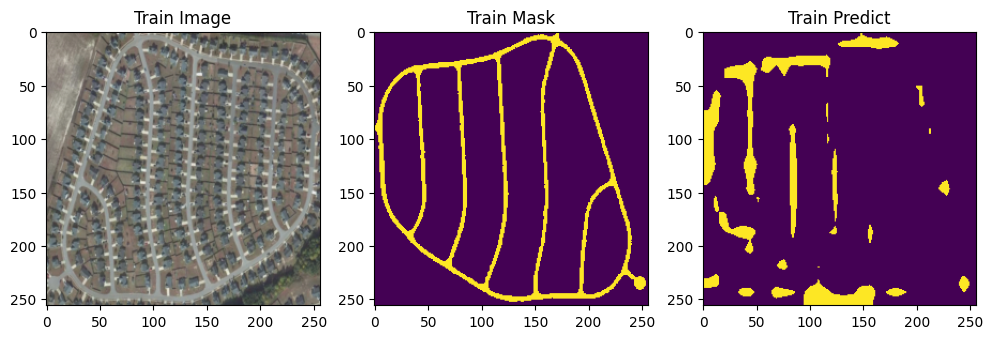


== Visualize kết quả trên ảnh VAL ==


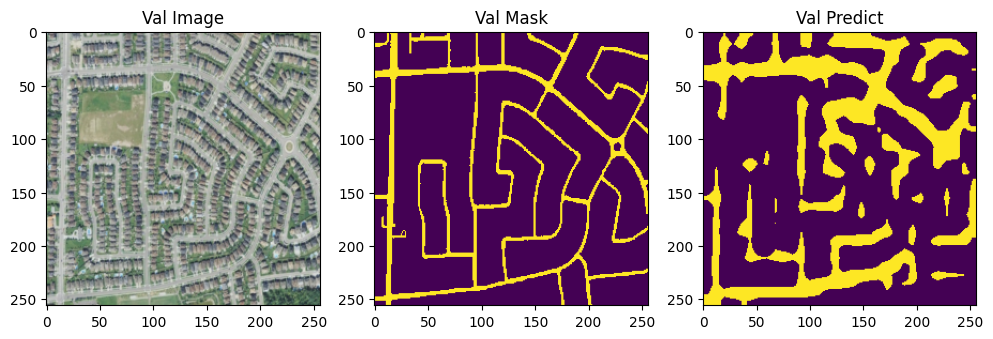


== mIoU TRAIN (full) == 0.6076300324562558
== mIoU VAL (full) == 0.5972402940624576
Saved masks to road/Train/unlabel_pred_refine_2


In [13]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import cv2

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def get_aug(size=(256,256)):
    return transforms.Compose([
        transforms.Resize(size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])

class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir=None, size=(256,256), filter_white=False, aug=False):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.size = size
        self.imgs = sorted([f for f in os.listdir(img_dir) if f.lower().endswith('.bmp')])
        if filter_white:
            imgs_valid = []
            for fname in self.imgs:
                img = Image.open(os.path.join(img_dir, fname)).convert('RGB').resize(size)
                arr = np.array(img)
                percent_white = ((arr > 240).all(axis=-1).sum()) / (arr.shape[0]*arr.shape[1])
                if percent_white < 0.9:
                    imgs_valid.append(fname)
            self.imgs = imgs_valid
        self.masks = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith('.bmp')]) if mask_dir else None
        self.img_tf = get_aug(size) if aug else transforms.Compose([
            transforms.Resize(self.size),
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        ])
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.img_dir, self.imgs[idx])).convert('RGB')
        img = self.img_tf(img)
        if self.masks:
            # Tìm mask đúng với ảnh (imageX.bmp -> X.bmp)
            maskname = self.imgs[idx].replace('image', '').replace('.bmp','') + '.bmp'
            mask = Image.open(os.path.join(self.mask_dir, maskname)).convert('L')
            mask = mask.resize(self.size, Image.NEAREST)
            mask = torch.from_numpy((np.array(mask) > 127).astype(np.uint8)).long()
            return img, mask
        else:
            return img

# ==== Model & Loss ====
class DiverseHeadNet(nn.Module):
    def __init__(self, num_classes=2, num_heads=8, dropout=0.3):
        super().__init__()
        self.backbone = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
        self.backbone.classifier = nn.Identity()
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(2048, 256, 3, padding=1),
                nn.ReLU(),
                nn.Dropout2d(dropout),
                nn.Conv2d(256, num_classes, 1)
            ) for _ in range(num_heads)
        ])
        self.num_heads = num_heads
    def forward(self, x):
        features = self.backbone.backbone(x)['out']
        return [head(features) for head in self.heads]

def voting_pseudo_label(head_outputs, phi=1.5, conf_thresh=0.85):
    stack = torch.stack([torch.softmax(o, dim=1) for o in head_outputs], dim=0)
    mean_pred = torch.mean(stack, dim=0)
    mean_label = torch.argmax(mean_pred, dim=1)
    mean_conf = mean_pred.max(dim=1)[0]
    pseudo_labels = [torch.argmax(o, dim=1) for o in head_outputs]
    votes = torch.zeros_like(mean_label, dtype=torch.float)
    for pl in pseudo_labels:
        votes += (pl == mean_label).float()
    votes = votes + phi
    final_label = (votes > (len(head_outputs)//2)).long()
    ignore_mask = (mean_conf < conf_thresh)
    final_label[ignore_mask] = 255
    return final_label

def dice_loss(pred, target, smooth=1.):
    pred = torch.softmax(pred, dim=1)[:,1]
    mask = (target == 1).float()
    pred = pred * (target != 255).float()
    mask = mask * (target != 255).float()
    intersection = (pred * mask).sum()
    union = pred.sum() + mask.sum()
    return 1 - ((2. * intersection + smooth) / (union + smooth))

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None, ignore_index=255):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index)
    def forward(self, input, target):
        ce_loss = self.ce(input, target)
        pt = torch.exp(-ce_loss)
        loss = ((1-pt)**self.gamma) * ce_loss
        return loss.mean()

def compute_miou(pred_mask, gt_mask, n_classes=2):
    ious = []
    for cls in range(n_classes):
        pred_i = (pred_mask == cls)
        gt_i   = (gt_mask == cls)
        inter = (pred_i & gt_i).sum()
        union = (pred_i | gt_i).sum()
        if union == 0:
            iou = float('nan')
        else:
            iou = inter / union
        ious.append(iou)
    ious = [iou for iou in ious if not np.isnan(iou)]
    if len(ious) == 0: return 0.0
    return np.mean(ious)

@torch.no_grad()
def eval_dataset_miou(model, dataset, device, n_classes=2, max_samples=None):
    model.eval()
    miou_list = []
    N = len(dataset) if max_samples is None else min(len(dataset), max_samples)
    for i in range(N):
        img, mask = dataset[i]
        img = img.unsqueeze(0).to(device)
        out = model(img)
        out_up = [nn.functional.interpolate(o, size=mask.shape[-2:], mode='bilinear', align_corners=False) for o in out]
        mean_pred = torch.mean(torch.stack([torch.softmax(o, dim=1) for o in out_up]), dim=0)
        pred_mask = torch.argmax(mean_pred, dim=1)[0].cpu().numpy()
        miou = compute_miou(pred_mask, mask.cpu().numpy(), n_classes)
        miou_list.append(miou)
    return np.nanmean(miou_list)

def refine_mask(mask_np):
    mask_np = mask_np.astype(np.uint8)
    kernel = np.ones((3,3), np.uint8)
    mask_np = cv2.morphologyEx(mask_np, cv2.MORPH_OPEN, kernel)
    mask_np = cv2.morphologyEx(mask_np, cv2.MORPH_CLOSE, kernel)
    return mask_np

def filter_small_blob(mask_np, min_area=100):
    n_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_np.astype(np.uint8), connectivity=8)
    filtered = np.zeros_like(mask_np)
    for i in range(1, n_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            filtered[labels == i] = 1
    return filtered

def train_semi(
    model, loader_l, loader_u, val_ds, optimizer, device,
    num_epochs=20, lambda_u=0.05, conf_thresh=0.85, warmup_epochs=4
):
    num_fg, num_bg = 0, 0
    for i in range(len(loader_l.dataset)):
        _, mask = loader_l.dataset[i]
        num_fg += (mask==1).sum().item()
        num_bg += (mask==0).sum().item()
    weight_bg = 1.0
    weight_fg = num_bg / (num_fg + 1e-8) if num_fg > 0 else 1.0
    weight_fg = min(weight_fg, 10.0)
    class_weights = torch.tensor([weight_bg, weight_fg]).to(device)
    print(f"== Class weights for loss: bg={weight_bg:.2f}, fg={weight_fg:.2f}")

    criterion = FocalLoss(gamma=2, weight=class_weights, ignore_index=255)
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        iter_u = iter(loader_u)
        for imgs_l, masks_l in loader_l:
            imgs_l, masks_l = imgs_l.to(device), masks_l.to(device)
            try:
                imgs_u = next(iter_u)
            except StopIteration:
                iter_u = iter(loader_u)
                imgs_u = next(iter_u)
            imgs_u = imgs_u.to(device)
            num_heads = model.num_heads
            frozen = np.random.choice(num_heads, num_heads // 2, replace=False)
            for i, head in enumerate(model.heads):
                for p in head.parameters():
                    p.requires_grad = False if i in frozen else True

            outputs_l = model(imgs_l)
            out_size = masks_l.shape[-2:]
            outputs_l_up = [nn.functional.interpolate(o, size=out_size, mode='bilinear', align_corners=False) for o in outputs_l]
            loss_sup = sum([
                0.5 * criterion(o, masks_l) + 0.5 * dice_loss(o, masks_l)
                for o in outputs_l_up
            ]) / num_heads

            if epoch < warmup_epochs:
                loss = loss_sup
            else:
                outputs_u = model(imgs_u)
                outputs_u_up = [nn.functional.interpolate(o, size=out_size, mode='bilinear', align_corners=False) for o in outputs_u]
                pseudo_label = voting_pseudo_label(outputs_u_up, conf_thresh=conf_thresh)
                head_idx = np.random.choice([i for i in range(num_heads) if i not in frozen])
                out_main = outputs_u_up[head_idx]
                loss_unsup = 0.5 * criterion(out_main, pseudo_label) + 0.5 * dice_loss(out_main, pseudo_label)
                loss = loss_sup + lambda_u * loss_unsup

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            for head in model.heads:
                for p in head.parameters():
                    p.requires_grad = True

        miou_train = eval_dataset_miou(model, loader_l.dataset, device, n_classes=2, max_samples=10)
        miou_val = eval_dataset_miou(model, val_ds, device, n_classes=2)
        print(f"Epoch {epoch+1}/{num_epochs}: loss={loss.item():.4f}, mIoU_train={miou_train:.4f}, mIoU_val={miou_val:.4f}")
    print("Training Done!")

def visualize_predict(model, ds, device, title=''):
    model.eval()
    with torch.no_grad():
        img, mask = ds[0]
        img_vis = img * torch.tensor(IMAGENET_STD).view(3,1,1) + torch.tensor(IMAGENET_MEAN).view(3,1,1)
        img_vis = (img_vis * 255).clip(0,255).byte().permute(1,2,0).cpu().numpy()
        out = model(img.unsqueeze(0).to(device))
        out_up = [nn.functional.interpolate(o, size=mask.shape[-2:], mode='bilinear', align_corners=False) for o in out]
        mean_pred = torch.mean(torch.stack([torch.softmax(o, dim=1) for o in out_up]), dim=0)
        pred_mask = torch.argmax(mean_pred, dim=1)[0].cpu().numpy()
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(img_vis); plt.title(f'{title} Image')
        plt.subplot(1,3,2); plt.imshow(mask.cpu()); plt.title(f'{title} Mask')
        plt.subplot(1,3,3); plt.imshow(pred_mask); plt.title(f'{title} Predict')
        plt.show()

def predict_and_save_unlabel(model, unlabel_folder, save_folder, device, size=(256,256)):
    os.makedirs(save_folder, exist_ok=True)
    ds_unlabel = SegmentationDataset(unlabel_folder, size=size, filter_white=True)
    model.eval()
    with torch.no_grad():
        for idx in range(len(ds_unlabel)):
            img = ds_unlabel[idx].unsqueeze(0).to(device)
            out = model(img)
            out_up = [nn.functional.interpolate(o, size=size, mode='bilinear', align_corners=False) for o in out]
            mean_pred = torch.mean(torch.stack([torch.softmax(o, dim=1) for o in out_up]), dim=0)
            pred_mask = torch.argmax(mean_pred, dim=1).squeeze().cpu().numpy().astype(np.uint8)
            pred_mask = refine_mask(pred_mask)
            pred_mask = filter_small_blob(pred_mask, min_area=60)
            fname = os.path.splitext(ds_unlabel.imgs[idx])[0]
            Image.fromarray(pred_mask * 255).save(os.path.join(save_folder, fname + '_pred.png'))
    print(f"Saved masks to {save_folder}")

if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_classes = 2
    num_heads = 8
    batch_size = 4

    train_img = 'road/Train/train_have_label_img'
    train_mask = 'road/Train/train_have_label_mask'
    val_img = 'road/Validation/image'
    val_mask = 'road/Validation/label'
    unlabel_img = 'road/Train/train_unlabel_img'

    ds_l = SegmentationDataset(train_img, train_mask, size=(256,256), aug=True)
    ds_val = SegmentationDataset(val_img, val_mask, size=(256,256))
    ds_u = SegmentationDataset(unlabel_img, size=(256,256), filter_white=True, aug=True)

    loader_l = DataLoader(ds_l, batch_size=batch_size, shuffle=True, drop_last=True)
    loader_u = DataLoader(ds_u, batch_size=batch_size, shuffle=True, drop_last=True)
    loader_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False)

    model = DiverseHeadNet(num_classes=num_classes, num_heads=num_heads, dropout=0.3)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    train_semi(
        model, loader_l, loader_u, ds_val, optimizer, device,
        num_epochs=20, lambda_u=0.05, conf_thresh=0.85, warmup_epochs=4
    )

    print("\n== Visualize kết quả trên ảnh TRAIN ==")
    visualize_predict(model, ds_l, device, title='Train')
    print("\n== Visualize kết quả trên ảnh VAL ==")
    visualize_predict(model, ds_val, device, title='Val')

    print("\n== mIoU TRAIN (full) ==", eval_dataset_miou(model, ds_l, device, n_classes=2))
    print("== mIoU VAL (full) ==", eval_dataset_miou(model, ds_val, device, n_classes=2))

    predict_and_save_unlabel(
        model,
        unlabel_folder=unlabel_img,
        save_folder='road/Train/unlabel_pred_refine_2',
        device=device,
        size=(256,256)
    )
